In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/tmp/ipykernel_8771/2426236682.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First load the *Spotify* dataset.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2023-11-08 10:31:32.013126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 10:31:32.101982: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Input shape: [18]


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 0 to 32832
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32828 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_album_id            32828 non-null  object 
 4   track_album_name          32828 non-null  object 
 5   track_album_release_date  32828 non-null  object 
 6   playlist_name             32828 non-null  object 
 7   playlist_id               32828 non-null  object 
 8   playlist_genre            32828 non-null  object 
 9   playlist_subgenre         32828 non-null  object 
 10  danceability              32828 non-null  float64
 11  energy                    32828 non-null  float64
 12  key                       32828 non-null  int64  
 13  loudness                  32828 non-null  float64
 14  mode       

2023-11-08 10:35:24.428050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Minimum Validation Loss: 0.1971


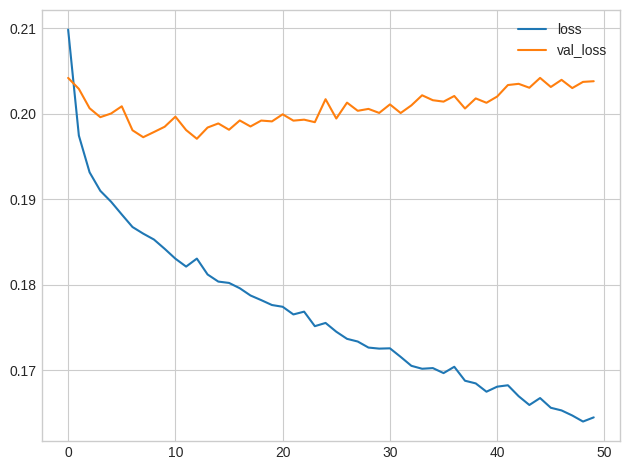

In [4]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Minimum Validation Loss: 0.1940


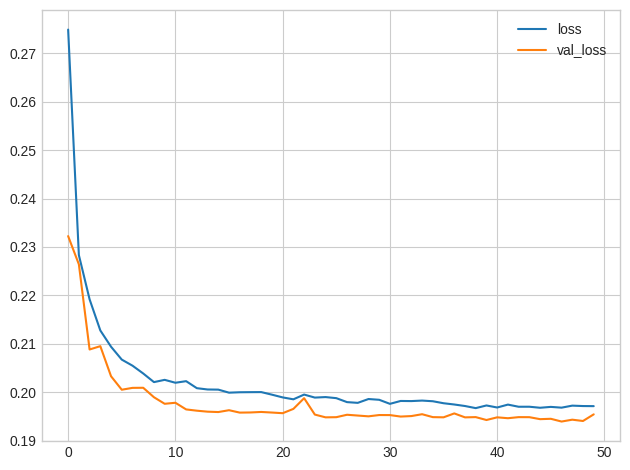

In [5]:
model2 = keras.Sequential([
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    optimizer='adam',
    loss='mae',
)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history2.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))